In [1]:
from tqdm.auto import tqdm
import torch 
from torch import nn
from transformers import RobertaTokenizer, PreTrainedTokenizer, DistilBertTokenizer, DistilBertModel, RobertaModel
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from torch.nn import CosineEmbeddingLoss
import transformers
#Build up to SBERT model 

In [2]:
deviceNum = 2
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")


In [3]:
def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [4]:
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTrainData.csv", sep="\t")
df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

#put ground truth values into a list 
df["ground_truth"] = df['Overall']

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[["ground_truth",  'text1', 'text2']].dropna()

#rescale data from (0, 4): (0, 1)
leanDf["ground_truth"] = 1 - ((leanDf["ground_truth"] - 1) / 3)


In [5]:
#get data loaded in properly 
dataset = Dataset.from_pandas(leanDf)

In [6]:
#link: https://huggingface.co/sentence-transformers/all-mpnet-base-v2
#example of tokenizing 
#tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
#tokenizer = AutoTokenizer.from_pretrained('Giyaseddin/distilbert-base-cased-finetuned-fake-and-real-news-dataset')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
example = dataset[0]["text1"]
first = tokenizer(example)

Just Sanity checking the special tokens

In [7]:
encoded = tokenizer(dataset[0]["text1"], dataset[0]["text2"])
tokenizer.decode(encoded["input_ids"])[:20]

Token indices sequence length is longer than the specified maximum sequence length for this model (667 > 512). Running this sequence through the model will result in indexing errors


'<s>MARTINSBURG, W.Va'

In [8]:
encoded = tokenizer(dataset[3]["text1"], dataset[3]["text2"])
tokenizer.decode(encoded["input_ids"])[:20]

'<s>Uber has sold its'

making sure that only_first works as expected

In [9]:
first = "hello world this is the first part" 
second = "OPE, and I think this will be the second"
encoded = tokenizer(first, second, truncation="longest_first",  max_length=10)
encoded

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


{'input_ids': [0, 42891, 232, 42, 2, 2, 23075, 6, 8, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
from transformers.utils import logging
logging.set_verbosity_error()
dataset = dataset.map(lambda x: tokenizer(x["text1"], x["text2"], max_length=500, padding="max_length", truncation=True))

  0%|          | 0/1676 [00:00<?, ?ex/s]

In [11]:
dataset = dataset.remove_columns(["text1", "text2", "__index_level_0__"])

In [12]:
# convert dataset features to PyTorch tensors
dataset.set_format(type='torch', columns=["ground_truth", "input_ids", "attention_mask"])

In [13]:
length = len(dataset)
print("total rows: " + str(length))
trainProp = .9 

validLen = int(length * (1-trainProp))
trainLen = length - validLen
print("train rows: " + str(trainLen) + "\nvalidation rows: " + str(validLen) + "\nsum: " + str(trainLen + validLen))

train, valid = torch.utils.data.random_split(dataset, [trainLen, validLen])

total rows: 1676
train rows: 1509
validation rows: 167
sum: 1676


In [14]:
# initialize the dataloader
batch_size = 3
trainLoader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True
)
validLoader = torch.utils.data.DataLoader(
    valid, batch_size=1, shuffle=True
)

In [15]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(token_embeddings, attention_mask):
     #First element of model_output contains all token embeddings
    #print(attention_mask.unsqueeze(-1).shape)
    #print(token_embeddings.size())
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [ ]:
class RDropModel(nn.Module): 
    def __init__(self):
        super(RDropModel,self).__init__()
        self.model = RobertaModel.from_pretrained('roberta-base')
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(.25)
        self.l1 = nn.Linear(768, 1).to(device)
        #self.l2 = nn.Linear(768, 1).to(device)
        self.loss_func = torch.nn.MSELoss(reduction="mean")
        
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, input_ids, attention_mask, gt): 
        
        #encode sentence and get mean pooled sentence representation 
        encoding = self.model(input_ids, attention_mask=attention_mask)[0]  #all token embeddings
        meanPooled = self.mean_pooling(encoding, attention_mask)
       
        #NOTE: Since dropout is random we simply send data through twice 
        #to get two predictions that have some noise 
        pred1 = self.l1(meanPooled)
        
        encoding = self.model(input_ids, attention_mask=attention_mask)[0]  #all token embeddings
        meanPooled = self.mean_pooling(encoding, attention_mask)
       
        #NOTE: Since dropout is random we simply send data through twice 
        #to get two predictions that have some noise 
        pred2 = self.l1(meanPooled)
    
        return pred1, pred2 
        
        return [loss, pred, gt] 


In [16]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel,self).__init__()
        #self.model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
        #self.model = AutoModel.from_pretrained('Giyaseddin/distilbert-base-cased-finetuned-fake-and-real-news-dataset')
        self.model = RobertaModel.from_pretrained('roberta-base')
        self.ReLU = nn.ReLU()
        #self.dropout = nn.Dropout(.25)
        self.l1 = nn.Linear(768, 1).to(device)
        #self.l2 = nn.Linear(768, 1).to(device)
        self.loss_func = torch.nn.MSELoss(reduction="mean")
        
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, input_ids, attention_mask, gt): 
        
        #encode sentence and get mean pooled sentence representation 
        encoding = self.model(input_ids, attention_mask=attention_mask)[0]  #all token embeddings
        meanPooled = self.mean_pooling(encoding, attention_mask)
       
        pred = self.l1(meanPooled)
        #out = self.dropout(out)
        #out = self.ReLU(out)
        #pred = self.l2(out)
        
        loss = self.loss_func(pred, gt.unsqueeze(1))
        
        return [loss, pred, gt] 


In [17]:
model = SimpleModel().to(device)

#TODO: double check on if reduction="mean" is the right move here...
#could cosine similarity also work..? I think that is between the two predicted vectors though.. 
loss_func = torch.nn.MSELoss(reduction="mean")

# we would initialize everything first
optim = torch.optim.Adam(model.parameters(), lr=2e-5)

EPOCHS = 4

# and setup a warmup for the first ~10% steps
total_steps = int((trainLen*EPOCHS) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)

In [18]:
def validation(): 
    model.eval()
    lossList = []
    pred = []
    GT = []

    i = True 
    for batch in validLoader: 
        # prepare batches and more all to the active device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['ground_truth'].to(device)

        #send batch info through model 
        loss, predSim, lab = model(input_ids, attention_mask,label)
        
        #get output metrics 
        lossList.append(loss.item())
        pred.append(float(predSim))
        GT.append(float(lab))
        
    #print(vGT)
    return [lossList, pred, GT]
        

In [19]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
trainDict = {}
lossList = []
validMetrics = []
trainMetrics = []
subLossList = []
# increase from 1 epoch if need be 
for epoch in range(EPOCHS):
    
    model.train()  # make sure model is in training mode
    
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(trainLoader, leave=True)
    
    validMetrics.append(validation())
    model.train()
    
    for i, batch in enumerate(loop): 
        # zero all gradients on each new step
        optim.zero_grad()

        # prepare batches and more all to the active device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label = batch['ground_truth'].to(device)

        #run batch through model 
        loss, pred, gt = model(input_ids, attention_mask, label)

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        
        #get mean loss over last 20 batches 
        if i % 20 == 0: 
            lossList.append(np.mean(subLossList))
            subLossList = []
        
        subLossList.append(float(loss.item()))
        
        # update learning rate scheduler
        scheduler.step()

        # update the TDQM progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
validMetrics.append(validation())

  0%|          | 0/503 [00:00<?, ?it/s]

/opt/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Train Loss')

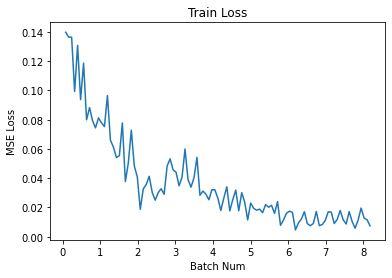

In [20]:
lossSmoothing = 20
lossIndex = [(i * lossSmoothing)/252 for i in range(len(lossList))]
plt.plot(lossIndex, lossList)
plt.xlabel("Batch Num")
plt.ylabel("MSE Loss")
plt.title("Train Loss")

In [21]:
len(train)

1509

In [22]:
validArr = np.array(validMetrics)
#print(validArr.shape)

validArr.shape

(5, 3, 167)

[[ 1.         -0.20816248]
 [-0.20816248  1.        ]]
[[1.         0.80926674]
 [0.80926674 1.        ]]
[[1.         0.83608604]
 [0.83608604 1.        ]]
[[1.         0.84182418]
 [0.84182418 1.        ]]
[[1.         0.84402927]
 [0.84402927 1.        ]]


Text(0.5, 1.0, 'validation eval')

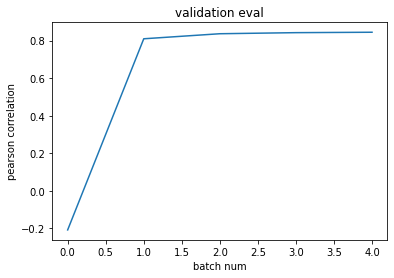

In [23]:
validArr = np.array(validMetrics)
#print(validArr.shape)

test = validArr[1,:,:]
#np.corrcoef(test[1], test[2])

iterList = []
corrList = []
#go through each validation step
for i in range(validArr.shape[0]): 
    subDf = pd.DataFrame(validArr[i].T)
    subDf.columns = ["loss", "pred", "true"]
    corr = np.corrcoef(subDf["pred"], subDf["true"])
    corrList.append(corr[1, 0])
    iterList.append(i)
    print(corr)
    
plt.plot(iterList, corrList)
plt.xlabel("batch num")
plt.ylabel("pearson correlation")
plt.title("validation eval")

Text(0, 0.5, 'prediction')

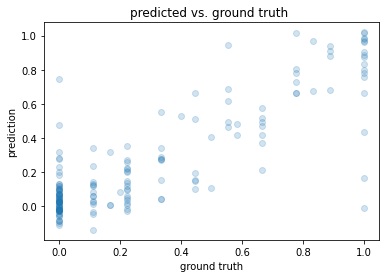

In [24]:
plt.scatter(subDf["true"], subDf["pred"], alpha = .2)
plt.title("predicted vs. ground truth ")
plt.xlabel("ground truth")
plt.ylabel("prediction")

NameError: name 'trainDf' is not defined

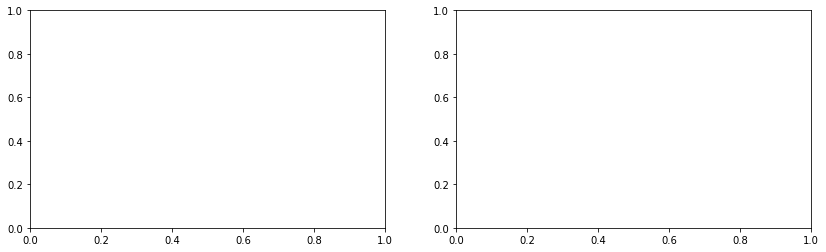

In [26]:
fig, axs = plt.subplots(1,2, figsize=[14,4])
axs[0].plot(trainDf["trainLoss"])
axs[0].set_title("Train Loss", size=14)
axs[0].set_ylabel("MSE Loss",size=14)
axs[0].set_xlabel("batch",size=14)

axs[1].plot(trainDf.dropna()["testLoss"])
axs[1].set_title("Validation Loss",size=14)
axs[1].set_ylabel("MSE Loss",size=14)
axs[1].set_xlabel("batch",size=14)

In [ ]:
print(x)
print(label)
print()

In [ ]:
loss_func(x, label)

In [ ]:
plt.plot(trainDf["testLoss"].dropna())

In [ ]:
valX

In [ ]:
vLabel

In [ ]:
x

In [ ]:
label